In [3]:
import os

os.chdir("..")
%load_ext autoreload

In [46]:
import warnings
import matplotlib.pyplot as plt
import shutil
import comet_ml
import numpy as np
import seaborn as sb
import pandas as pd
import torch
from monai.transforms import Rotate90, Compose
from sklearn.metrics import r2_score

warnings.simplefilter("ignore")
api = comet_ml.api.API(
    api_key="WmA69YL7Rj2AfKqwILBjhJM3k",
)

## Analysis of discrete labelling

In [11]:
drop = pd.read_csv(r"C:\Users\Brico\Downloads\mcdropout-res(1).csv")
drop['count']=drop['count'].apply(eval)
drop['max classe']=drop['count'].apply(np.argmax)
drop['labels']=drop['labels'].astype(int)
drop['confidence']=drop['count'].apply(max)
drop

,Unnamed: 0,mean,std,labels,count,max classe,confidence
0,0,0.00,0.000000,0,"[100, 0, 0]",0,100
1,1,1.01,0.100000,1,"[0, 99, 1]",1,99
2,2,2.00,0.000000,2,"[0, 0, 100]",2,100
3,3,0.46,0.500908,0,"[54, 46, 0]",0,54
4,4,2.00,0.000000,2,"[0, 0, 100]",2,100
...,...,...,...,...,...,...,...
84,84,2.00,0.000000,2,"[0, 0, 100]",2,100
85,85,2.00,0.000000,2,"[0, 0, 100]",2,100
86,86,0.14,0.348735,0,"[86, 14, 0]",0,86
87,87,2.00,0.000000,2,"[0, 0, 100]",2,100


In [14]:
base_accuracy = (drop['labels'] == drop['mean'].astype(int)).sum() / len(drop)
base_accuracy

0.797752808988764

In [30]:
def get_prop_acc(df:pd.DataFrame, confidence:int):
    filtered = df[df['confidence']>=confidence]
    filtered_accuracy = (filtered['labels'] == filtered['max classe'].astype(int)).sum() / len(filtered)
    filtered_prop = len(filtered)/len(df)
    return filtered_accuracy, filtered_prop

In [37]:
get_prop_acc(drop, 100)

(0.8448275862068966, 0.651685393258427)

In [33]:
accs = []
props = []
for i in range(50,101):
    (a,p)=get_prop_acc(drop, confidence=i)
    accs.append(a)
    props.append(p)

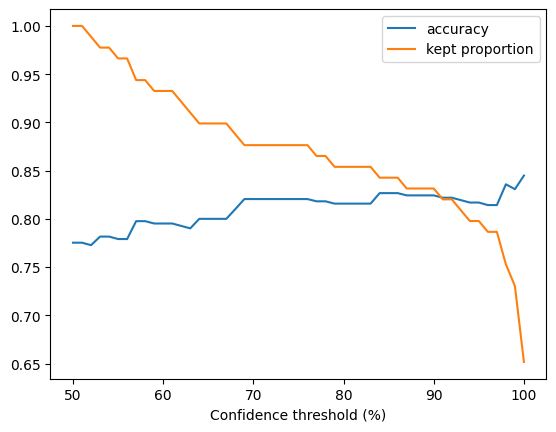

In [36]:
plt.plot(range(50,101),accs, label="accuracy")
plt.plot(range(50,101),props, label="kept proportion")
plt.xlabel("Confidence threshold (%)")
plt.legend()

Text(0.5, 1.0, 'Label against Prediction with 100% confidence')

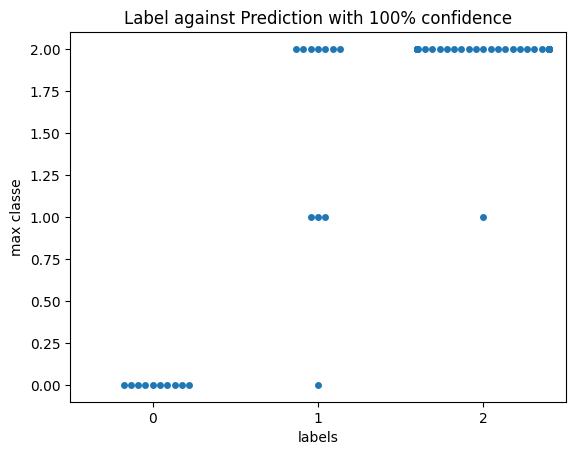

In [41]:
sb.swarmplot(drop[drop['confidence']>=100], x="labels", y="max classe")
plt.title("Label against Prediction with 100% confidence")

## Analysis of continuous labelling

Max r2 is 0.8586616516113281

<Axes: xlabel='std', ylabel='Count'>

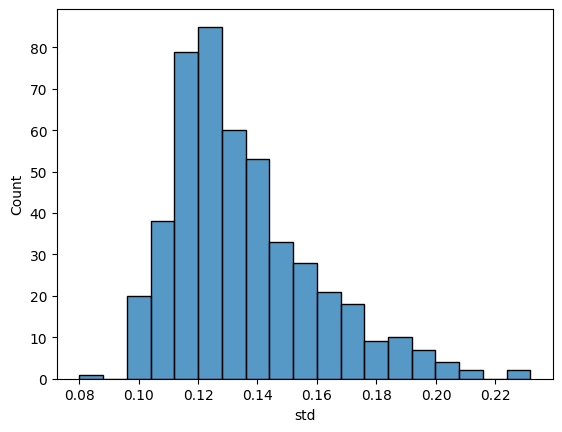

In [50]:
drop = pd.read_csv(r"C:\Users\Brico\Downloads\mcdropout-res-50565(1).csv")
sb.histplot(drop, x="std")

In [86]:
def get_prop_mse_r2(df:pd.DataFrame, std:float):
    filtered = df[df['std']<=std]
    mse = ((filtered['mean']-filtered['labels'])**2).mean()
    r2 = r2_score(filtered['labels'], filtered['mean'])
    filtered_prop = len(filtered)/len(df)
    return mse, r2, filtered_prop

In [89]:
mses = []
r2s = []
props = []
x=np.arange(0.09,0.23, 0.01)

for i in x:
    (m,r,p)=get_prop_mse_r2(drop, i)
    mses.append(m)
    r2s.append(r)
    props.append(p)

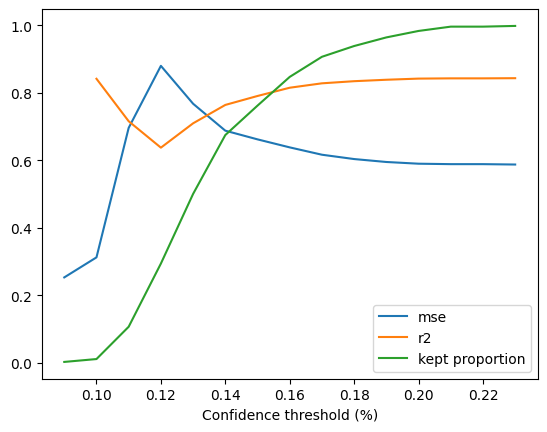

In [90]:
plt.plot(x,np.array(mses)*10, label="mse")
plt.plot(x,r2s, label="r2")
plt.plot(x,props, label="kept proportion")
plt.xlabel("Confidence threshold (%)")
plt.legend()